In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
# ===== 문서 로딩 & 분할 =====
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1498, chunk_overlap=198)
loader = Docx2txtLoader('./tax.docx')
temp = loader.load_and_split(text_splitter=text_splitter)
document_list = temp[0:80]

In [7]:
# ===== 임베딩 & Vector DB =====
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embedding = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    collection_name='chroma-tax',
    embedding_function=embedding,
    persist_directory='./chroma-tax'
)
retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [8]:
# ===== 상태 정의 =====
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [9]:
# ===== LLM 준비 =====
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o-mini')

# ===== RAG 기반 generate =====
from langchain import hub
generate_prompt = hub.pull('rlm/rag-prompt')

def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})
    state['answer'] = response
    return state

c:\workspace\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
# ===== 문서 관련성 판단 =====
doc_releveance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevence(state: AgentState):
    query = state['query']
    context = state['context']
    doc_relevance_chain = doc_releveance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    return 'generate' if response['Score'] == 1 else 'rewrite'

c:\workspace\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
# ===== rewrite =====
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사랑과 관련된 표현 -> 거주자']
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리 사전을 참고해서 사용자의 질문을 변경해 주세요.
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    state['query'] = response
    return state


In [12]:
# ===== tools =====
def tools(state: AgentState) -> AgentState:
    """
    Tools 노드: generate/rewrite 수행 후 agent로 돌아감
    """
    next_step = check_doc_relevence(state)
    if next_step == 'generate':
        return generate(state)
    else:
        rewritten_state = rewrite(state)
        return rewritten_state

In [20]:
# ===== StateGraph 구성 =====
builder = StateGraph(AgentState)
builder.add_node("agent", lambda s: s)  # retrieve 대신 lambda 예시
builder.add_node("tools", tools)

builder.add_edge(START, 'agent')
builder.add_edge('agent', END)        # agent에서 바로 END 가능
builder.add_edge('agent', 'tools')    # agent에서 tools로 분기
builder.add_edge('tools', 'agent')    # tools 처리 후 agent로 돌아감

graph = builder.compile()

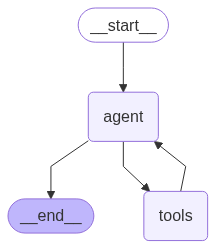

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


### 내가 해본 방법

In [16]:
# 검색
def retrieve(state: AgentState) -> AgentState:
    query = state["query"]
    docs = retriever.get_relevant_documents(query)
    return {**state, "context": docs}

# 답변 생성
def generate(state: AgentState) -> AgentState:
    context_texts = "\n".join([d.page_content for d in state["context"]])
    answer = llm.invoke(f"질문: {state['query']}\n\n참고 문맥:\n{context_texts}")
    return {**state, "answer": answer.content}

# 질문 리라이트
def rewrite(state: AgentState) -> AgentState:
    new_query = llm.invoke(f"다음 질문을 더 검색 친화적으로 다시 써줘: {state['query']}")
    return {**state, "query": new_query.content}

In [17]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

# 노드 등록
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)
builder.add_node("rewrite", rewrite)

# 분기 연결
builder.add_edge(START, "retrieve")

# retrieve → generate or rewrite (조건 분기)
def branch_after_retrieve(state: AgentState):
    if len(state["context"]) > 0:   
        return "generate"
    else:                           
        return "rewrite"

builder.add_conditional_edges("retrieve", branch_after_retrieve,
                              {"generate": "generate", "rewrite": "rewrite"})

# generate → END
builder.add_edge("generate", END)

# rewrite → retrieve (루프)
builder.add_edge("rewrite", "retrieve")

graph = builder.compile()


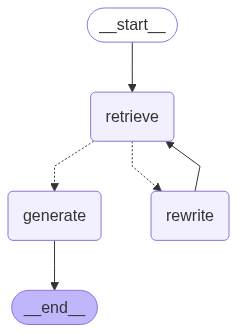

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
inputs = {"query": "연봉 5천만원 직장인의 소득세는? ", "context": [], "answer": ""}
result = graph.invoke(inputs)
print(result["answer"])

C:\Users\USER\AppData\Local\Temp\ipykernel_17032\3918439501.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


연봉 5천만원을 받는 직장인의 소득세는 다음과 같이 대략적으로 계산할 수 있습니다. 한국의 소득세는 누진세 구조로 되어 있어, 소득 구간에 따라 세율이 다르게 적용됩니다.

2023년 기준으로, 개인소득세의 세율은 다음과 같습니다:

- 1,200만원 이하: 6%
- 1,200만원 초과 ~ 4,600만원 이하: 15%
- 4,600만원 초과 ~ 8,800만원 이하: 24%

연봉 5천만원의 경우, 세금 계산은 다음과 같습니다.

1. **과세표준 계산**: 연봉 5천만원에서 비과세 소득이나 공제를 제외한 금액을 과세표준으로 합니다. 여기서는 간단화를 위해 비과세 소득이나 공제를 고려하지 않고 계산하겠습니다.

2. **소득세 계산**:
   - 1,200만원까지: 1,200만원 × 6% = 72만원
   - 1,200만원 초과 4,600만원까지: (4,600만원 - 1,200만원) × 15% = 51만원
   - 4,600만원 초과 5,000만원까지: (5,000만원 - 4,600만원) × 24% = 96만원

3. **총 소득세**: 
   - 72만원 + 51만원 + 96만원 = 219만원

따라서, 연봉 5천만원을 받는 직장인의 대략적인 소득세는 약 219만원입니다. 다만, 개인의 세무 상황에 따라 공제 항목이나 추가 세금이 있을 수 있으므로, 정확한 세액은 세무사와 상담하거나 국세청의 세금 계산기를 이용하는 것이 좋습니다.
